In [1]:
import pandas as pd
from fbprophet import Prophet
from etl_resources import sqlite_connection
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
def base_df():
    
    '''
    This function returns the base time series dataframe (date and close)
    '''
    
    con = sqlite_connection()
        
    df = pd.read_sql("select * from weekly_prices_clean where ticker='AMZN'",con=con)
    
    df[['ds', 'y']] = df[['date','close']]
    df = df[['ds', 'y']]
        
    return df

In [3]:
def train_test_split(df, split=0.2):
    
    test_rows = int(round(df.shape[0] * split,0))
    train_rows = df.shape[0] - test_rows
    
    test_df = df.head(test_rows).copy()
    train_df = df.tail(train_rows).copy()
    
    return train_df, test_df

Initial log joint probability = -78.4352
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2706.59     0.0536785       3018.26           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2841.25    0.00246616       1288.68      0.6945      0.6945      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2868.51    0.00321226       328.136           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2881.84     0.0046574       276.096           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       2883.62   0.000136257       504.928   4.207e-07       0.001      539  LS failed, Hessian reset 
     499       2886.08   0.000639054    

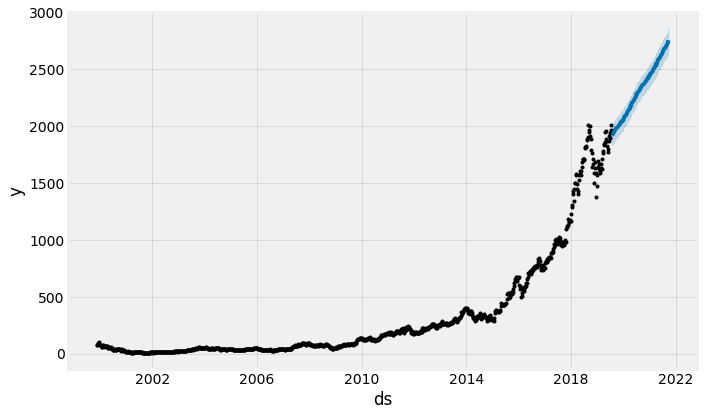

In [4]:
df = base_df()
train, test = train_test_split(df, split=0.1)
model = Prophet(daily_seasonality=True)
model.fit(train)
forecast = model.predict(test)
forecast.tail()

fig = model.plot(forecast)